## MLP Model for Diabetes Prediction

This notebook builds, trains, and evaluates an MLP model for predicting diabetes. The goal is to improve the recall for the minority class (Diabetes) while maintaining a high overall accuracy.


## 1. Import Libraries

First, we import the necessary libraries for data manipulation, model building, training, and evaluation.

In [4]:

# Importing necessary libraries
import tensorflow as tf
import keras_tuner
from tensorflow.keras import layers, models, regularizers
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras_tuner.tuners import RandomSearch 
from tensorflow.keras.optimizers import Adam


## 2. Load and Preprocess the Dataset

Next, we load the dataset and handle any missing values. We also perform feature selection, one-hot encode the target variable, and split the data into training and testing sets.

In [5]:
# Load and prepare the dataset
data = pd.read_csv('balanced_diabetes_dataset.csv')
data['gender'] = data['gender'].fillna(data['gender'].mode()[0])

# Define feature set and target variable
X = data[['log_bmi', 'log_HbA1c_level', 'log_blood_glucose_level', 'gender', 'smoking_history', 'hypertension', 'heart_disease']]
y = tf.keras.utils.to_categorical(data['diabetes'], num_classes=2)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
# Define the feature set (X) and target variable (y)
log_cols = ['log_bmi', 'log_HbA1c_level', 'log_blood_glucose_level']
X = data[log_cols + ['gender', 'smoking_history', 'hypertension', 'heart_disease']]
y = data['diabetes']

# One-hot encode the target variable for categorical crossentropy
y = tf.keras.utils.to_categorical(y, num_classes=2)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the feature set
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 3. Define and Compile the MLP Model

We define the architecture of the MLP model using Keras' Sequential API and compile it with an appropriate loss function, optimizer, and metric.

In [7]:
# Learning rate scheduler function
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch < 20:
        return lr * 0.1
    else:
        return lr * 0.01

# Initial Training with More Layers and Neurons
mlp_model = models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(2, activation='softmax')
])

mlp_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/Users/hannahjoshua/Desktop/ODL_CODE/env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 4. Train the MLP Model with Early Stopping

We train the model using early stopping to prevent overfitting. Class weights are applied to address class imbalance.

In [8]:
# Callbacks for stable training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
lr_schedule = LearningRateScheduler(lr_scheduler)

# Train the model with updated parameters
history = mlp_model.fit(
    X_train, y_train,
    epochs=40,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr, lr_schedule],
    batch_size=64
)

# Evaluate the model
initial_eval = mlp_model.evaluate(X_test, y_test)
print(f'Updated Initial Model Accuracy: {initial_eval[1]:.4f}')

Epoch 1/40
170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7767 - loss: 0.5613 - val_accuracy: 0.8301 - val_loss: 0.5108 - learning_rate: 0.0010
Epoch 2/40
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8476 - loss: 0.3864 - val_accuracy: 0.8581 - val_loss: 0.3957 - learning_rate: 0.0010
Epoch 3/40
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8586 - loss: 0.3588 - val_accuracy: 0.8787 - val_loss: 0.3222 - learning_rate: 0.0010
Epoch 4/40
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8646 - loss: 0.3436 - val_accuracy: 0.8776 - val_loss: 0.3103 - learning_rate: 0.0010
Epoch 5/40
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8561 - loss: 0.3499 - val_accuracy: 0.8813 - val_loss: 0.3034 - learning_rate: 0.0010
Epoch 6/40
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8669 - loss: 0.3330 - val_accuracy: 0.8849 - val_loss: 0.2982 - learning_rate: 0.0010
Epoch 7/40
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8727 - loss: 0.3222 - 

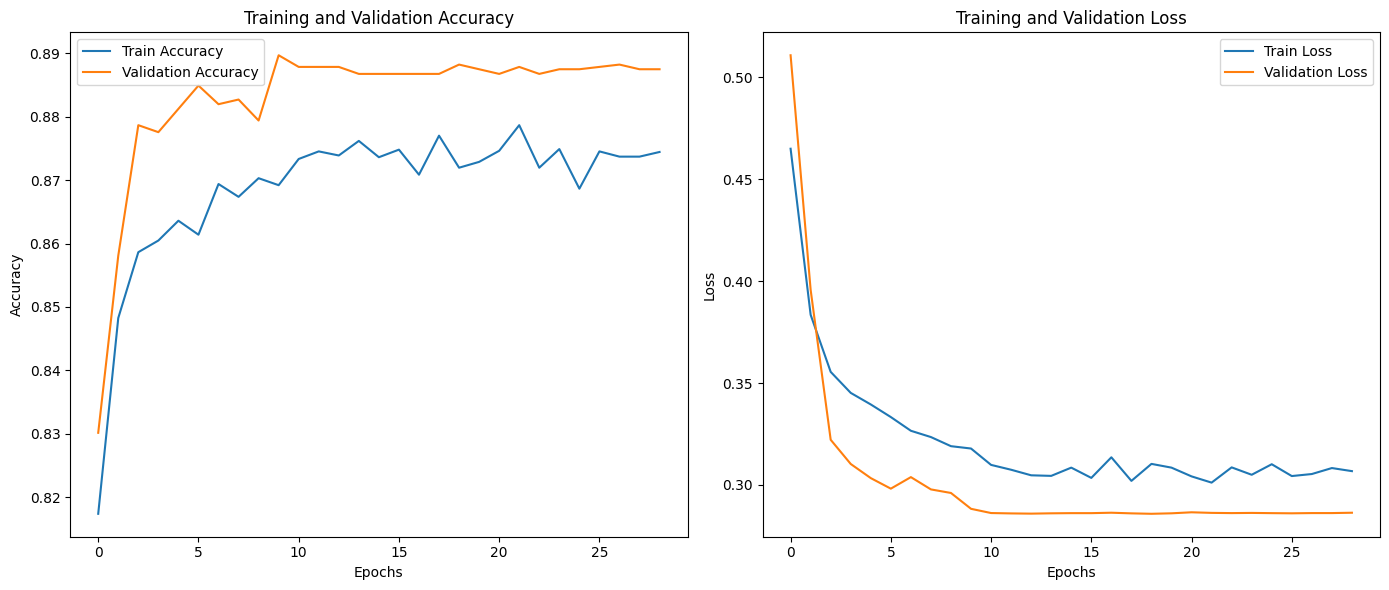

The best epoch was Epoch 10:
  - Training Accuracy: 0.87
  - Validation Accuracy: 0.89
  - Training Loss: 0.3179
  - Validation Loss: 0.2883


In [9]:

# Plot training & validation accuracy and loss
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
# Find the index of the epoch with the best validation accuracy
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy']))

# Extract the corresponding metrics
best_train_accuracy = history.history['accuracy'][best_epoch]
best_val_accuracy = history.history['val_accuracy'][best_epoch]
best_train_loss = history.history['loss'][best_epoch]
best_val_loss = history.history['val_loss'][best_epoch]

# Print the best epoch metrics in words
print(f"The best epoch was Epoch {best_epoch + 1}:")
print(f"  - Training Accuracy: {best_train_accuracy:.2f}")
print(f"  - Validation Accuracy: {best_val_accuracy:.2f}")
print(f"  - Training Loss: {best_train_loss:.4f}")
print(f"  - Validation Loss: {best_val_loss:.4f}")

## 5. Evaluate the MLP Model

After training, we evaluate the model's performance on the test data using a confusion matrix, classification report, and ROC curve.

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


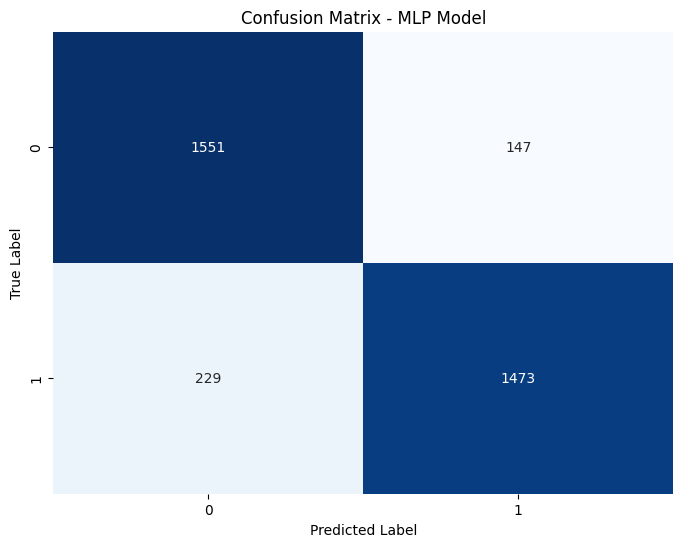

Classification Report - MLP Model:
               precision    recall  f1-score   support

 No Diabetes       0.87      0.91      0.89      1698
    Diabetes       0.91      0.87      0.89      1702

    accuracy                           0.89      3400
   macro avg       0.89      0.89      0.89      3400
weighted avg       0.89      0.89      0.89      3400



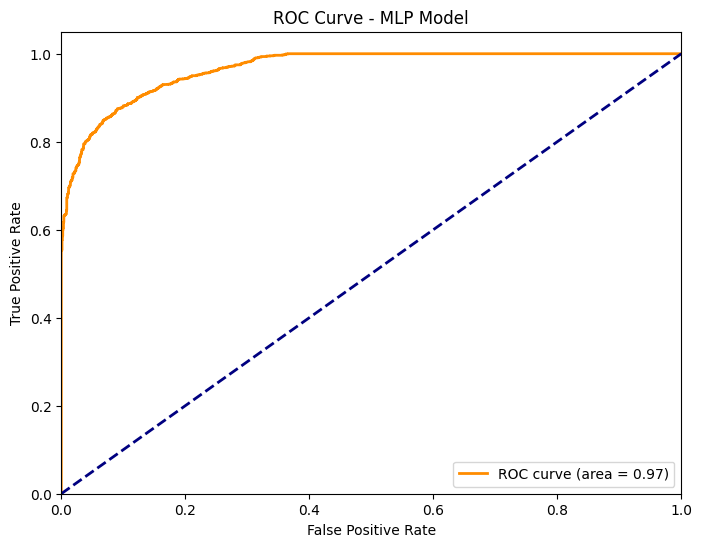

In [10]:
# Step 5: Evaluate the MLP Model
y_pred_probs_mlp = mlp_model.predict(X_test)  # Predict probabilities
y_pred_classes_mlp = np.argmax(y_pred_probs_mlp, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test, axis=1)  # True labels

# Confusion Matrix
conf_matrix_mlp = confusion_matrix(y_true, y_pred_classes_mlp)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - MLP Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
report_mlp = classification_report(y_true, y_pred_classes_mlp, target_names=['No Diabetes', 'Diabetes'])
print("Classification Report - MLP Model:\n", report_mlp)

# ROC Curve and AUC
fpr_mlp, tpr_mlp, _ = roc_curve(y_true, y_pred_probs_mlp[:, 1])
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

plt.figure(figsize=(8, 6))
plt.plot(fpr_mlp, tpr_mlp, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MLP Model')
plt.legend(loc="lower right")
plt.show()

## 6. Hyperparameter Tuning with Keras Tuner

We perform hyperparameter tuning using Keras Tuner to find the optimal configuration for the MLP model.

In [12]:
# Define the model-building function for Keras Tuner
def build_model(hp):
    model = models.Sequential()
    
    # Number of layers (between 2 to 6)
    for i in range(hp.Int('num_layers', 2, 6)):
        model.add(layers.Dense(units=hp.Int(f'units_{i}', min_value=64, max_value=512, step=64),
                               activation='relu',
                               kernel_regularizer=regularizers.l2(hp.Choice(f'l2_reg_{i}', [0.0001, 0.0005, 0.001]))))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Output layer
    model.add(layers.Dense(2, activation='softmax'))
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Initialize the Keras Tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,  # Number of different models to try
    executions_per_trial=2,  # Number of times to evaluate each model
    directory='mlp_hyperparameter_tuning',
    project_name='diabetes_mlp_tuning'
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=30, validation_split=0.2, callbacks=[early_stopping], batch_size=64)

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Evaluate the best model on the test data
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Print the best hyperparameters
print("Best Hyperparameters:")
for param, value in best_hyperparameters.values.items():
    print(f"{param}: {value}")

Reloading Tuner from mlp_hyperparameter_tuning/diabetes_mlp_tuning/tuner0.json
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8955 - loss: 0.2495
Test Accuracy: 0.8874
Best Hyperparameters:
num_layers: 4
units_0: 256
l2_reg_0: 0.0005
dropout_0: 0.2
units_1: 448
l2_reg_1: 0.0001
dropout_1: 0.30000000000000004
learning_rate: 0.001
units_2: 320
l2_reg_2: 0.0005
dropout_2: 0.4
units_3: 192
l2_reg_3: 0.0001
dropout_3: 0.30000000000000004
units_4: 448
l2_reg_4: 0.001
dropout_4: 0.2
units_5: 512
l2_reg_5: 0.0001
dropout_5: 0.30000000000000004


In [13]:
# Assuming you have run the Keras Tuner search and retrieved the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the model summary
print("Best Model Summary:")
best_model.summary()

# Print the best hyperparameters
print("\nBest Hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")

Best Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (64, 256)              │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (64, 256)              │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (64, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (64, 448)              │       115,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (64, 448)              │         1,792 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (64, 448)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (64, 320)              │       143,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (64, 320)              │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (64, 320)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (64, 192)              │        61,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (64, 192)              │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (64, 192)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (64, 2)                │           386 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 327,746 (1.25 MB)

 Trainable params: 325,314 (1.24 MB)

 Non-trainable params: 2,432 (9.50 KB)


Best Hyperparameters:
num_layers: 4
units_0: 256
l2_reg_0: 0.0005
dropout_0: 0.2
units_1: 448
l2_reg_1: 0.0001
dropout_1: 0.30000000000000004
learning_rate: 0.001
units_2: 320
l2_reg_2: 0.0005
dropout_2: 0.4
units_3: 192
l2_reg_3: 0.0001
dropout_3: 0.30000000000000004
units_4: 448
l2_reg_4: 0.001
dropout_4: 0.2
units_5: 512
l2_reg_5: 0.0001
dropout_5: 0.30000000000000004


## 7. Evaluate the Tuned MLP Model

Finally, we evaluate the performance of the best model found through hyperparameter tuning.

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report - Tuned MLP Model:
               precision    recall  f1-score   support

 No Diabetes       0.91      0.86      0.88      1698
    Diabetes       0.87      0.91      0.89      1702

    accuracy                           0.89      3400
   macro avg       0.89      0.89      0.89      3400
weighted avg       0.89      0.89      0.89      3400



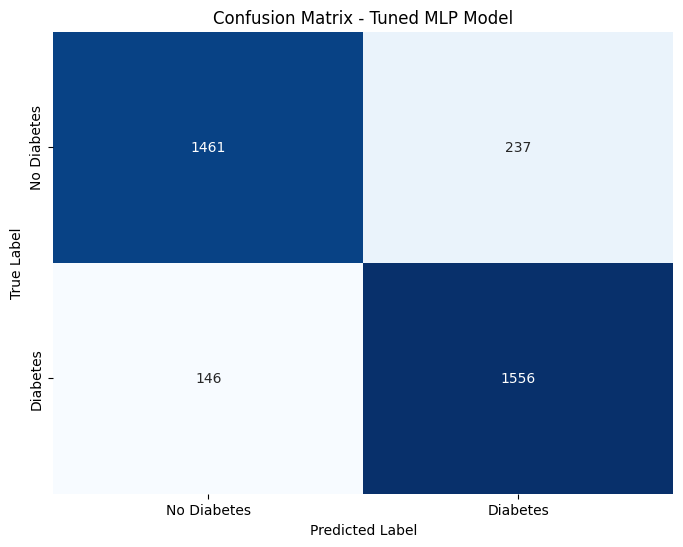

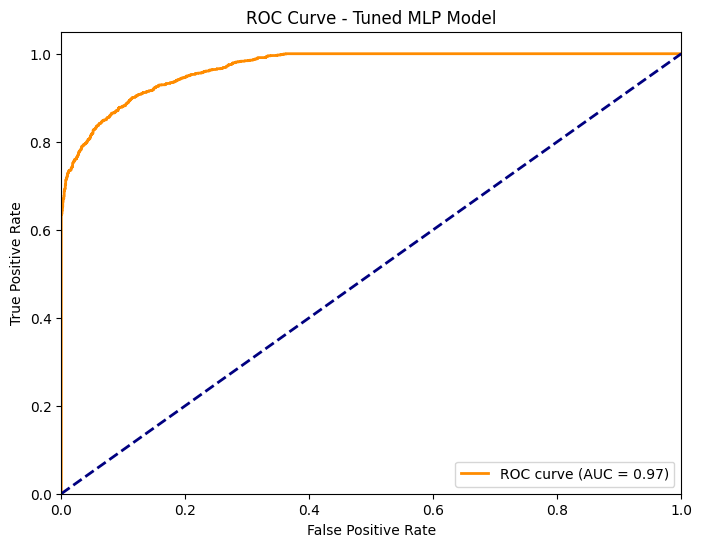

In [14]:
# Predict the probabilities on the test set using the best model
y_pred_probs = best_model.predict(X_test)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Get the true class labels
y_true = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_true, y_pred_classes, target_names=['No Diabetes', 'Diabetes'])
print("Classification Report - Tuned MLP Model:\n", report)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Tuned MLP Model')
plt.show()

# Calculate the ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_probs[:, 1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Tuned MLP Model')
plt.legend(loc="lower right")
plt.show()